<a href="https://www.spe.org/events/en/2022/conference/22apog/asia-pacific-oil-and-gas-conference-and-exhibition.html"><img src = "https://www.spe.org/binaries/content/gallery/specms/speevents/organization-logos/spe-logo-2020.png" width = 200> 

<h1 align=center><font size = 5>Prediction of Recovery Factor using Machine Learning Methods</font></h1>

<h1 align=center><font size = 4> Munish Kumar, Kannapan Swaminathan</font></h1>
<h1 align=center><font size = 4> Part 4a: Simplied Experiment Collinearity</font></h1>
<h1 align=center><font size = 3> ERCE 2022 </font></h1>

###### References

1. https://www.kaggle.com/code/kkhandekar/an-introduction-to-pycaret/notebook.
2. https://towardsdatascience.com/5-things-you-dont-know-about-pycaret-528db0436eec
3. https://www.dataquest.io/blog/understanding-regression-error-metrics/ 
4. https://www.analyticsvidhya.com/blog/2021/07/automl-using-pycaret-with-a-regression-use-case/
5. https://www.datacamp.com/community/tutorials/guide-for-automating-ml-workflows-using-pycaret
6. https://pycaret.readthedocs.io/en/latest/api/regression.html
7. http://www.pycaret.org/tutorials/html/REG102.html
8. https://githubhelp.com/ray-project/tune-sklearn

## Check PyCaret Version

In [1]:
from pycaret.utils import version

In [2]:
version()

'2.3.6'

#### Libraries

In [3]:
# Only install the following libraries if you dont have it, otherwise leave it commented out

#!conda install -c anaconda natsort --yes
#!conda install -c anaconda xlrd --yes

#!pip install natsort --user
#!pip install xlrd --user
#!pip install pycaret[full] --user
#!pip install mlflow --user
#!pip install tune-sklearn ray[tune] --user
#!pip install optuna -- user
#!pip install hyperopt --user
#!pip install redis --user

# General Libraries
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter
import time
import re
import requests
import pickle
import seaborn as sns
import os
import glob
import sys
from natsort import natsorted
sns.set()

import plotly.graph_objects as go
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

# Sklearn Liraries
from sklearn import preprocessing

import datetime
from datetime import timedelta, date 
start = time.time()
%matplotlib inline

import ray
from ray import tune

# Forces the print statement to show everything and not truncate
# np.set_printoptions(threshold=sys.maxsize) 
print('Libraries imported')

Libraries imported


In [4]:
#Receive Data
#dir_name = r'C:\Users\kswaminathan\OneDrive\01_KannaLibrary\15_Analogs'
#dir_name = r'C:\Users\mkumar\Documents\GitHub\@Papers\SPE2022\Final'
dir_name = r'C:\Users\mkumar\Documents\GitHub\@Papers\SPE2022\Final\2_GOM_MODEL'
filename_suffix = 'csv'

##### Read in the data 

In [5]:
skiprows = 0
#Means read in the ',' as thousand seperator. Also drops all columns which are unnamed.
df = pd.read_excel("dfBOEMGOM.xlsx", thousands=',', skiprows = skiprows)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')] 
df.head()

,CHRONOZONE,Original Oil,SS,THK,TAREA,DRIVE,POROSITY,SW,PERMEABILITY,Pi,TI,RSI,API,BOI,ORF
0,PLL,1315672,3700,7.94,255,WTR,0.35,0.16,1997,1750,118.33,190,24,1.120,0.32
1,PLL,4070162,3800,62.09,86,WTR,0.32,0.16,1416,1797,119.33,239,25,1.124,0.41
2,PLL,6586236,3800,67.83,169,WTR,0.32,0.16,1416,1797,119.33,239,25,1.124,0.31
3,PLL,59160,4775,5.00,40,WTR,0.35,0.31,364,2254,123.33,379,30,1.189,0.19
4,PU,3724947,5249,15.47,360,WTR,0.34,0.28,415,2477,138.33,309,23,1.112,0.46


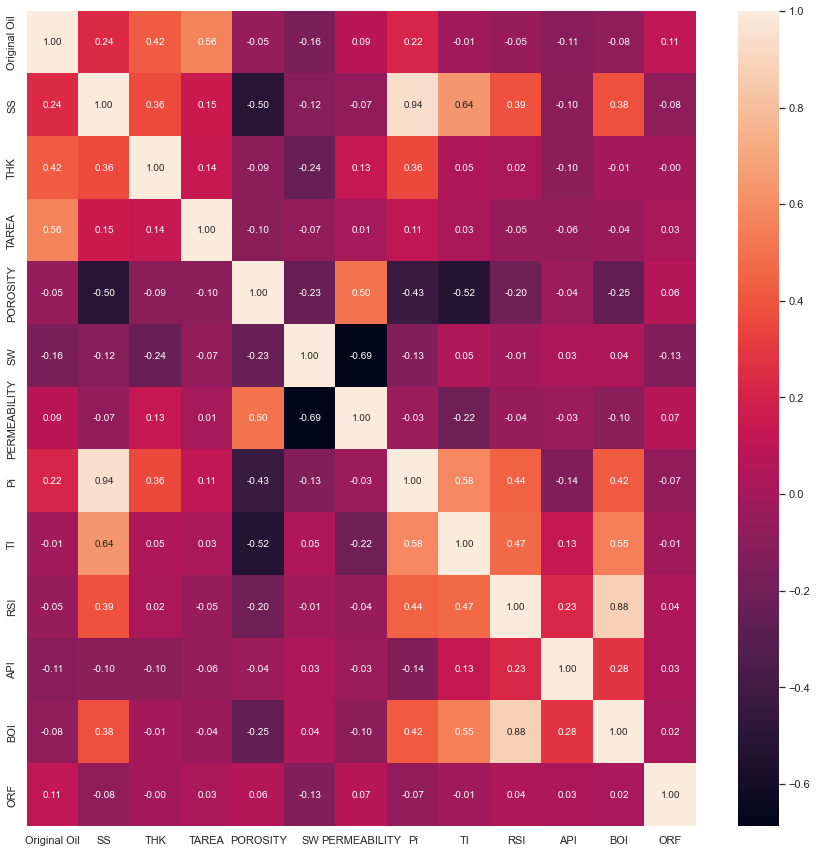

In [6]:
# Plot as Heat map to check for highly correlated variables
plt.figure(figsize=(15, 15))
ax = sns.heatmap(df.corr(), annot=True, fmt=".2f")

In observing the heat map above, I define highly correlated variables as having collinearity coeeficients of > 0.7. There was no highly correlated values

##### Convert to float - to ensure it is a numerical feature

In [7]:
df_drop = df.copy()
#df_drop = df_drop.astype(float)
df_drop = df_drop[df_drop['ORF']<0.51]

# Confirm properties of final dataframe
print(len(df_drop))
print(df_drop.info())
print(df_drop.describe(include='all'))
print(df_drop.columns.values)

3945
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3945 entries, 0 to 4511
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CHRONOZONE    3945 non-null   object 
 1   Original Oil  3945 non-null   int64  
 2   SS            3945 non-null   int64  
 3   THK           3945 non-null   float64
 4   TAREA         3945 non-null   int64  
 5   DRIVE         3945 non-null   object 
 6   POROSITY      3945 non-null   float64
 7   SW            3945 non-null   float64
 8   PERMEABILITY  3945 non-null   int64  
 9   Pi            3945 non-null   int64  
 10  TI            3945 non-null   float64
 11  RSI           3945 non-null   int64  
 12  API           3945 non-null   int64  
 13  BOI           3945 non-null   float64
 14  ORF           3945 non-null   float64
dtypes: float64(6), int64(7), object(2)
memory usage: 493.1+ KB
None
       CHRONOZONE  Original Oil            SS          THK         TAREA  \
count       

Final Data set has 4511 rows and 15 columns.

### Train, Validation, and Test Split

In [8]:
# Creates a mask where values that are true go into the training/test set
# Note that I done it so that the random number is predictable

msk = np.random.seed(0)
msk = np.random.rand(len(df_drop))<0.8

raw_train_validate_set = df_drop[msk]
raw_test_set = df_drop[~msk]

print(raw_train_validate_set.shape)
print(raw_test_set.shape)

(3134, 15)
(811, 15)


In [9]:
raw_train_validate_set.to_excel(r'dfssoil.xlsx', index = False, header=True)
raw_test_set.to_excel(r'BlindTest_SSOIL.xlsx', index = False, header=True)

We split the data set 80-20 into a "train-validate" set and a "test" set. The test set is external asn will never be seen by the model.

## 1. Pycaret Implementation

Pycaret will be used in the machine learning portion. Pycaret is a low-code machine learning library in Python that automates machine learning workflows. One of its key benefits is its ability to run a large number of differnt machine learning algorithms, but with only a few lines of code

In [10]:
skiprows = 0
#Means read in the ',' as thousand seperator. Also drops all columns which are unnamed.
df = pd.read_excel("dfssoil.xlsx", thousands=',', skiprows = skiprows)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')] 
df.head()

,CHRONOZONE,Original Oil,SS,THK,TAREA,DRIVE,POROSITY,SW,PERMEABILITY,Pi,TI,RSI,API,BOI,ORF
0,PLL,1315672,3700,7.94,255,WTR,0.35,0.16,1997,1750,118.33,190,24,1.120,0.32
1,PLL,4070162,3800,62.09,86,WTR,0.32,0.16,1416,1797,119.33,239,25,1.124,0.41
2,PLL,6586236,3800,67.83,169,WTR,0.32,0.16,1416,1797,119.33,239,25,1.124,0.31
3,PLL,59160,4775,5.00,40,WTR,0.35,0.31,364,2254,123.33,379,30,1.189,0.19
4,PU,3724947,5249,15.47,360,WTR,0.34,0.28,415,2477,138.33,309,23,1.112,0.46


In [11]:
from pycaret.regression import *

#Create a copy
model_df = df_drop.copy()
target = 'ORF'

# no resampling
clf_none = setup(
            data=model_df,
            target=target,
            session_id=42,
            normalize=True,
            transformation = True,
            ignore_low_variance=True,
            remove_outliers = True, #outliers_threshold = 0.2,
            #remove_multicollinearity = True, multicollinearity_threshold = 0.7,
            train_size=0.7)

,Description,Value
0,session_id,42
1,Target,ORF
2,Original Data,"(3945, 15)"
3,Missing Values,False
4,Numeric Features,12
5,Categorical Features,2
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(2623, 28)"


In [12]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.0708,0.0082,0.0906,0.5885,0.0716,0.5650,0.8080
lightgbm,Light Gradient Boosting Machine,0.0733,0.0088,0.0935,0.5608,0.0740,0.5742,0.0630
gbr,Gradient Boosting Regressor,0.0785,0.0094,0.0968,0.5304,0.0767,0.6612,0.0720
rf,Random Forest Regressor,0.0790,0.0096,0.0978,0.5198,0.0776,0.6987,0.1930
et,Extra Trees Regressor,0.0800,0.0099,0.0994,0.5041,0.0789,0.7403,0.1360
xgboost,Extreme Gradient Boosting,0.0779,0.0099,0.0994,0.5035,0.0788,0.6272,0.1640
br,Bayesian Ridge,0.0924,0.0132,0.1147,0.3408,0.0920,1.0621,0.0040
ridge,Ridge Regression,0.0923,0.0132,0.1148,0.3400,0.0920,1.0582,0.0040
lr,Linear Regression,0.0923,0.0132,0.1148,0.3397,0.0920,1.0578,0.3890
huber,Huber Regressor,0.0917,0.0133,0.1154,0.3319,0.0926,1.0414,0.0130


In [13]:
top3 = compare_models(include=['gbr', 'catboost', 'lightgbm'], fold = 10, sort='MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.0708,0.0082,0.0906,0.5885,0.0716,0.5650,0.7950
lightgbm,Light Gradient Boosting Machine,0.0733,0.0088,0.0935,0.5608,0.0740,0.5742,0.0660
gbr,Gradient Boosting Regressor,0.0785,0.0094,0.0968,0.5304,0.0767,0.6612,0.0750


There is a performance improvement in going from 5 folds to 10 folds for all 3 models. To keep computation time reasonable, folds is kept at 10.

----------------------------------------------------------------------------------------------------------------------------

## 3. Optimisation

### a. Tune the Model

In [14]:
tuned_models = []

In [15]:
rf = create_model('gbr', fold = 10)
rf = tune_model(rf, 
                optimize = 'R2', 
                n_iter = 50, 
                #choose_better = True, #Choose "True" had no effect meaning that model was already optimised
                 #search_library = "tune-sklearn", 
                 #search_algorithm="Hyperopt",
                 #search_algorithm="Optuna",
                 #search_algorithm="bayesian",
                )
tuned_models.append(rf)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0814,0.0101,0.1005,0.5038,0.0797,0.6826
1,0.0779,0.0090,0.0951,0.5433,0.0759,0.5914
2,0.0753,0.0094,0.0972,0.4825,0.0771,0.6493
3,0.0713,0.0079,0.0891,0.5765,0.0710,0.6327
4,0.0775,0.0091,0.0953,0.5215,0.0756,0.7567
5,0.0765,0.0084,0.0918,0.5924,0.0732,0.6767
6,0.0744,0.0087,0.0930,0.5743,0.0733,0.6295
7,0.0783,0.0096,0.0978,0.5566,0.0769,0.6642
8,0.0790,0.0095,0.0972,0.5526,0.0769,0.6610
9,0.0776,0.0095,0.0974,0.5270,0.0772,0.5992


rf = tune_model(rf, 
                optimize = 'RMSE', 
                n_iter = 50, 
                choose_better = True, 
                 #search_library = "tune-sklearn", 
                 #search_algorithm="Hyperopt",
                 #search_algorithm="Optuna",
                 #search_algorithm="bayesian",
                )
tuned_models.append(rf)

knn = create_model('knn', fold = 10)
knn = tune_model(knn, 
                optimize = 'RMSE', 
                n_iter = 50, 
                choose_better = True, 
                 #search_library = "tune-sklearn", 
                 #search_algorithm="Hyperopt",
                 #search_algorithm="Optuna",
                 #search_algorithm="bayesian",
                )
tuned_models.append(knn)

catboost = create_model('catboost', fold = 10)
catboost = tune_model(catboost, 
                optimize = 'RMSE', 
                n_iter = 50, 
                choose_better = True, 
                 #search_library = "tune-sklearn", 
                 #search_algorithm="Hyperopt",
                 #search_algorithm="Optuna",
                 #search_algorithm="bayesian",
                )
tuned_models.append(catboost)

## 5. Finalise the model

In [16]:
final_et = finalize_model(rf)
#final_et = finalize_model(et)

### Plots to analyse Model

In [17]:
model = final_et
predict_model(model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.0687,0.0073,0.0857,0.6418,0.0675,0.5343


,Original Oil,SS,THK,TAREA,POROSITY,SW,PERMEABILITY,Pi,TI,RSI,...,CHRONOZONE_PLU-LL,CHRONOZONE_PU,DRIVE_COM,DRIVE_DEP,DRIVE_PAR,DRIVE_SLG,DRIVE_UNK,DRIVE_WTR,ORF,Label
0,0.007293,0.922486,-0.773793,0.431502,0.340747,-0.789567,1.071214,0.943023,1.731940,-1.502176,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.26,0.292589
1,1.318566,0.487911,-1.252483,2.027587,-0.822519,-0.519225,-0.071463,0.222332,0.698286,0.009374,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.30,0.333256
2,0.065554,-0.401567,0.395723,1.240772,-0.555238,-0.134662,-0.180944,-0.690223,-0.399167,-0.367460,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.33,0.251472
3,-0.939014,0.932120,0.977081,-0.603314,-0.555238,0.546612,-0.777549,0.525472,1.218364,-1.270305,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.33,0.140378
4,-0.226674,-0.783265,-0.488698,-0.034369,0.023240,-0.012750,0.812795,-0.337764,-2.251316,-0.267534,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.20,0.259302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1179,0.604983,-1.060284,0.177129,0.750377,1.023708,-0.928517,1.774341,-0.584026,-2.480309,0.085041,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.11,0.274571
1180,-0.788589,-0.753979,-1.061071,-1.086558,0.340747,-1.069839,1.166263,-1.067096,-1.231574,-0.638336,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.35,0.341766
1181,0.046288,0.937291,-0.539970,-0.067438,-0.555238,-0.259843,0.079555,1.172175,1.244183,1.607567,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.46,0.356080
1182,0.595386,0.993763,-0.374520,1.766175,0.023240,-0.653096,0.893000,0.935486,1.347304,1.941583,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.30,0.314045


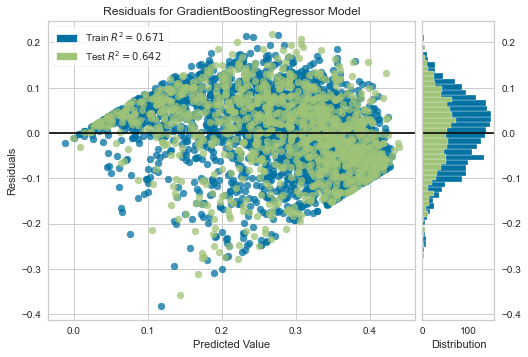

In [18]:
plot_model(model)

## 6. Blind Test

In [19]:
dfblind = pd.read_excel("BlindTest_SSOIL.xlsx", thousands=',', skiprows = skiprows)
#dfblind = dfblind.loc[:, ~df.columns.str.contains('^Unnamed')] 
dfblind.head()

,CHRONOZONE,Original Oil,SS,THK,TAREA,DRIVE,POROSITY,SW,PERMEABILITY,Pi,TI,RSI,API,BOI,ORF
0,MUU,6491880,7791,13.07,1040,DEP,0.31,0.20,852,3669,173.33,575,30,1.294,0.35
1,MUU,6612660,7511,23.63,633,WTR,0.26,0.33,165,3538,171.33,567,31,1.237,0.40
2,MUU,1796305,7925,14.12,380,WTR,0.26,0.27,252,5238,173.33,917,31,1.480,0.33
3,MUU,924752,10751,11.96,257,PAR,0.26,0.28,142,7315,203.33,1191,36,1.564,0.32
4,MUU,89593809,11783,74.66,3021,PAR,0.27,0.21,365,8653,220.33,1624,33,1.763,0.42


In [20]:
BlindPredict = predict_model(final_et, data=dfblind, round=2)

In [21]:
BlindPredict

,CHRONOZONE,Original Oil,SS,THK,TAREA,DRIVE,POROSITY,SW,PERMEABILITY,Pi,TI,RSI,API,BOI,ORF,Label
0,MUU,6491880,7791,13.07,1040,DEP,0.31,0.20,852,3669,173.33,575,30,1.294,0.35,0.341564
1,MUU,6612660,7511,23.63,633,WTR,0.26,0.33,165,3538,171.33,567,31,1.237,0.40,0.401883
2,MUU,1796305,7925,14.12,380,WTR,0.26,0.27,252,5238,173.33,917,31,1.480,0.33,0.365370
3,MUU,924752,10751,11.96,257,PAR,0.26,0.28,142,7315,203.33,1191,36,1.564,0.32,0.348002
4,MUU,89593809,11783,74.66,3021,PAR,0.27,0.21,365,8653,220.33,1624,33,1.763,0.42,0.395424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
806,PLL,248701,7044,15.67,36,PAR,0.25,0.18,397,5397,172.33,1189,34,1.623,0.45,0.382451
807,MMM,2021622,21300,15.91,752,WTR,0.22,0.16,537,13924,194.33,1171,32,1.503,0.18,0.216190
808,MUM,20619359,10315,49.82,1234,COM,0.28,0.23,410,5585,153.33,1396,30,1.785,0.36,0.373771
809,PL,1386360,15271,45.15,41,WTR,0.30,0.17,946,11850,221.33,747,18,1.238,0.48,0.372544


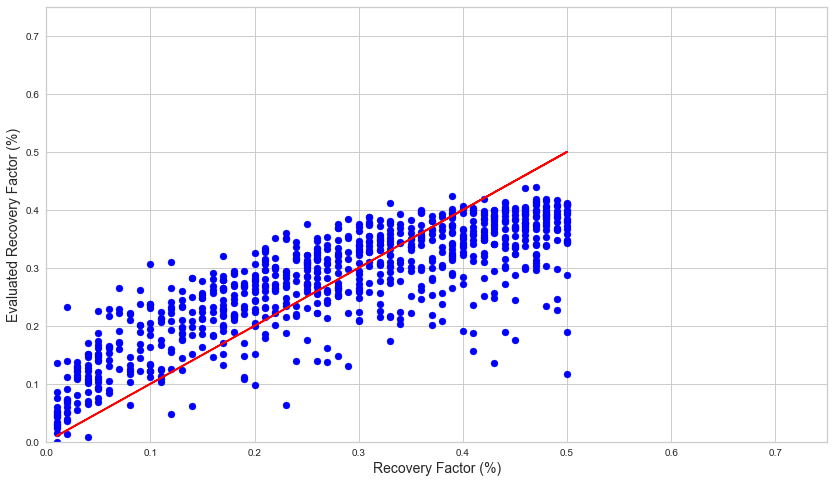

In [25]:
a = BlindPredict['ORF']
b = BlindPredict['Label']

plt.figure(figsize=(14, 8))
plt.scatter(a, b, color='blue')
plt.plot(a, a, color = 'red', label = 'x=y')
plt.xlabel("Recovery Factor (%)", size=14)
plt.ylabel("Evaluated Recovery Factor (%)", size=14)
plt.xlim([0, 0.75])
plt.ylim([0, 0.75])

#plt.tight_layout()
plt.show()

In [23]:
count = 'Completed Process'
elapsed = (time.time() - start)
print ("%s in %s seconds" % (count,elapsed))

Completed Process in 68.1268093585968 seconds
